Radio based Fingerprinting ML Algorithm for indoor localization


Executive summary

Using wireless communication signals for high precision indoor localization/positioning is a problem of great interest and has a wide variety of applications. It has traditionally been tackled with geometrical algorithms. However, research has shown that the ML techniques can improve the accuracy of positioning algorithms. This project explores training ML Models using "RF fingerprinting" dataset that can precisely determine a location of an object / tag based on its unique "RF fingerprint".

Rationale

Traditional GPS fails to operate effectively within buildings, tunnels, or complex structures. Having high-accuracy, real-time location data (often at sub-meter or centimeter-level) enables, optimizes, and secures operations in environments where knowing "where" is as important as "what". Here are a few example applications - Locating items/inventory in warehouses, tracking patient flow in hospitals, location based advertising/coupon delivery in malls, assisting first responders in navigating dangerous indoor environment during emergency operations and so on.

Research Question

Can we create a machine learning model for a given indoor environment that can accurately ouput a position/location of an entity based on the "RF fingerprint" data collected by the radio tag/device attached to the entity?

Data Sources

Thanks to the Fraunhofer Institute for Integrated Circuits IIS for making available a great data source below which is in HDF5 file format. This project utilized the UWB dataset. 
https://www.iis.fraunhofer.de/en/ff/lv/dataanalytics/pos/fingerprinting-dataset-for-positioning.html

The link also contains the detailed description of the dataset and the collection methodology.


STEP 1: Read the HDF5 Data and study the structure of the UWB dataset

In [8]:
import re   
import h5py
import pandas as pd
import numpy as np
from   pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.preprocessing import StandardScaler
from   sklearn.model_selection import train_test_split
import torch
from   torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Read the UWB data file and print the structure of the dataset

datafile_path = Path("uwb_dataset") / "uwb_training_data.hdf5"

with h5py.File(datafile_path, "r") as f:
    def walk(name, obj):
        if isinstance(obj, h5py.Dataset):
            print("Dataset:", name, "shape:", obj.shape)
    f.visititems(walk)



Dataset: A_ID shape: (143920,)
Dataset: B_ID shape: (143920,)
Dataset: CIR_I shape: (143920, 366)
Dataset: CIR_R shape: (143920, 366)
Dataset: POS_X shape: (143920,)
Dataset: POS_Y shape: (143920,)
Dataset: TD shape: (143920,)
Dataset: TD_OFFSET shape: (143920,)
Dataset: TIME_STAMP shape: (143920,)


STEP 2 
Read each dataset in the hdf5 file into separate dataframes and confirm the shape of each dataframe

In [9]:
# Create a dictionary of dataframes from the hdf5 dataset keys


if "dfs" not in globals() or not isinstance(dfs, dict) or not dfs:
    dfs = {}
    with h5py.File(datafile_path, "r") as f:
        def collect(name, obj):
            if isinstance(obj, h5py.Dataset):
                dfs[name] = pd.DataFrame(obj[...])
        f.visititems(collect)

# Create variables for each dataframe and print their shapes
created_dataframes = {}

for dataset_name, df in dfs.items():
    safe_name = re.sub(r"\W+", "_", dataset_name.lower()).strip("_")
    var_name = f"df_{safe_name}" if safe_name else "df_dataset"
    created_dataframes[var_name] = df
    globals()[var_name] = df
    print(f"{var_name}: {df.shape}")

df_a_id: (143920, 1)
df_b_id: (143920, 1)
df_cir_i: (143920, 366)
df_cir_r: (143920, 366)
df_pos_x: (143920, 1)
df_pos_y: (143920, 1)
df_td: (143920, 1)
df_td_offset: (143920, 1)
df_time_stamp: (143920, 1)


STEP 3:
Combine all dataframes into a single dataframe

In [10]:
# Combine all DataFrames from `dfs` into one DataFrame (column-wise) To ensure unique column names, we can prefix each column with the dataset name. This way, we avoid any potential column name collisions when concatenating the DataFrames.

combined_df = pd.concat(
    [df_part.add_prefix(f"{name}_") for name, df_part in dfs.items()],
    axis=1
)

print("Combined DataFrame shape:", combined_df.shape)

Combined DataFrame shape: (143920, 739)


STEP 4: Understand the number of unique values for A_ID (Transciever IDs) and B_ID (identifiers for tags recording CIRs from Transcievers)

In [ ]:
# Print number of unique values in A_ID, B_ID, and TIME_STAMP columns
print(f"Unique A_ID values: {combined_df['A_ID_0'].nunique()}")
print(f"Unique B_ID values: {combined_df['B_ID_0'].nunique()}")
print(f"Unique TIME_STAMP values: {combined_df['TIME_STAMP_0'].nunique()}")

Unique A_ID values: 6
Unique B_ID values: 25581
Unique TIME_STAMP values: 143920


STEP 5: For the purpose of this project, corresponding CIR_i and CIR_r values can be combined into a single CIR-t value without any loss of the fingerprint information. So, modify the dataframe accordingly. This will also reduce the number of "features" / columns in the combined dataframe

In [11]:
# Add CIR_T_* columns computed from matching CIR_I_* and CIR_R_* columns
# CIR_T = sqrt (CIR_I**2 + CIR_R**2)

cir_i_cols = [c for c in combined_df.columns if c.startswith("CIR_I_")]
cir_r_col_set = {c for c in combined_df.columns if c.startswith("CIR_R_")}

cir_t_data = {}
for col_i in cir_i_cols:
    suffix = col_i.replace("CIR_I_", "")
    col_r = f"CIR_R_{suffix}"
    if col_r in cir_r_col_set:
        cir_t_data[f"CIR_T_{suffix}"] = np.hypot(combined_df[col_i], combined_df[col_r])

if cir_t_data:
    cir_t_df = pd.DataFrame(cir_t_data, index=combined_df.index)
    combined_df = pd.concat([combined_df, cir_t_df], axis=1)

#print("New combined_df shape:", combined_df.shape)
#print(combined_df.head(1))

In [12]:
# Drop all CIR_I and CIR_R columns from combined_df
cols_to_drop = [col for col in combined_df.columns if col.startswith('CIR_I_') or col.startswith('CIR_R_')]
combined_df = combined_df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns")
print(f"New combined_df shape: {combined_df.shape}")

Dropped 732 columns
New combined_df shape: (143920, 373)


STEP 6: Visualize a "RF Fingerprint" sample

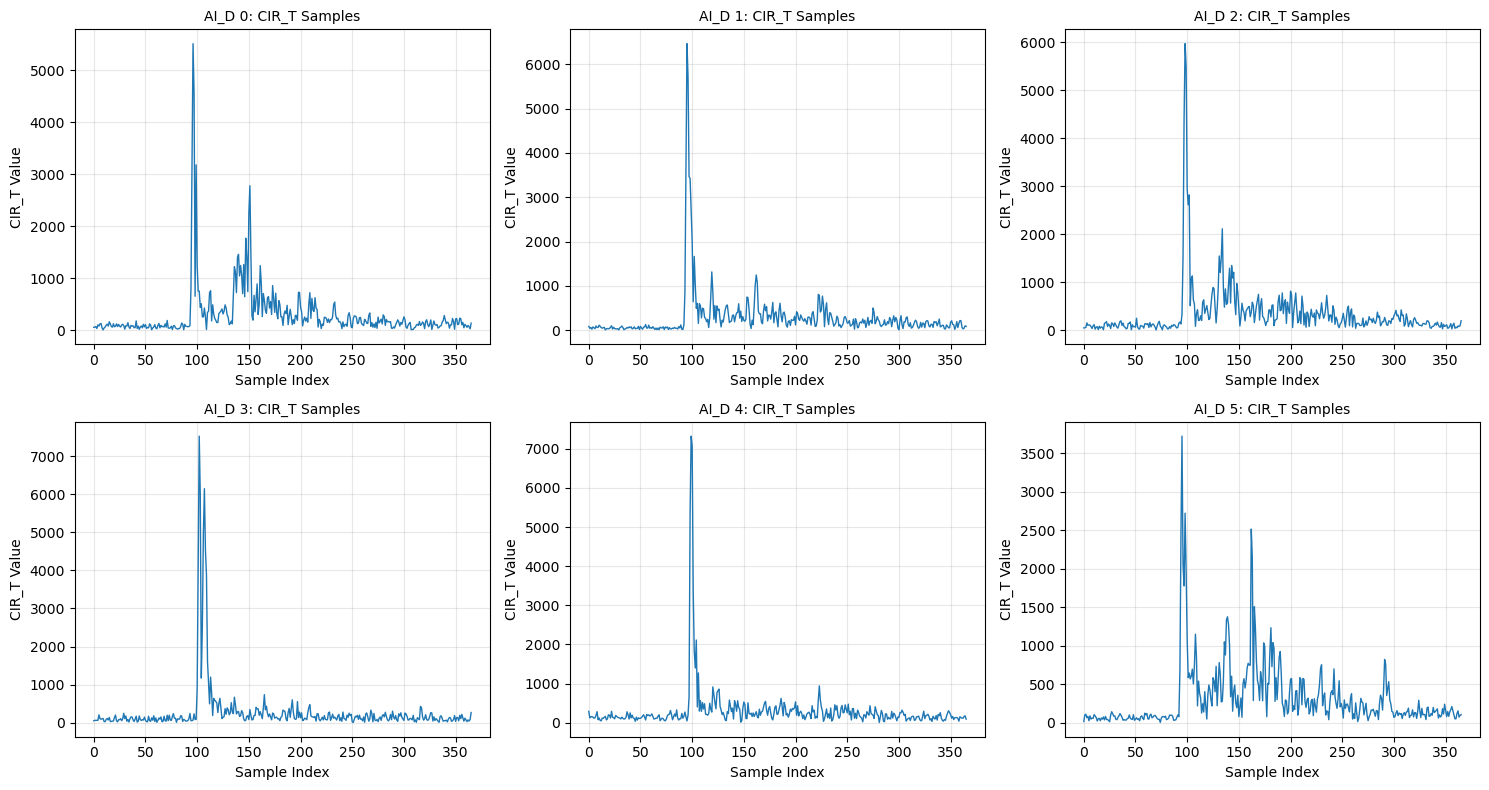

In [ ]:
# Plot CIR_T samples for the first 6 rows of combined_df in a 2x3 grid of subplots
# This represents the complete "RF fingerprint observed bythe first tag (B_ID) across six AI_Ds (transmitters) at a location (POS_X, POS_Y)"
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

cir_t_cols = [col for col in combined_df.columns if col.startswith('CIR_T_')]

for idx in range(6):
    ax = axes[idx]
    cir_values = combined_df[cir_t_cols].iloc[idx].values
    ax.plot(cir_values, linewidth=1)
    ax.set_title(f'AI_D {idx}: CIR_T Samples', fontsize=10)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CIR_T Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

STEP 7: Convert the units of the positioning and timing data and examine the range of values of all the key columns

In [13]:
# Multiply POS_X and POS_Y columns by 100 (meters --> centimeters); multiply TD and TD_OFFSET by 10**9 (seconds --> nanoseconds)
combined_df['POS_X_0'] = combined_df['POS_X_0'] * 100
combined_df['POS_Y_0'] = combined_df['POS_Y_0'] * 100
combined_df['TD_0'] = combined_df['TD_0'] * 10**9
combined_df['TD_OFFSET_0'] = combined_df['TD_OFFSET_0'] * 10**9

In [14]:
# Get all columns except A_ID and CIR columns
non_cir_cols = [col for col in combined_df.columns if not col.startswith('CIR_') and col != 'A_ID_0']

# Print min and max values for each column
for col in non_cir_cols:
    print(f"{col}: min={combined_df[col].min()}, max={combined_df[col].max()}")

B_ID_0: min=3597, max=34729
POS_X_0: min=1372.1354933420726, max=3396.003202676433
POS_Y_0: min=776.1023294415519, max=2358.701969486587
TD_0: min=3.240908754909836, max=221.27509179069938
TD_OFFSET_0: min=-73.319245607425, max=189.19050693511963
TIME_STAMP_0: min=1614875461.744175, max=1614882627.119457


STEP 8: Visualize the positioning ground truth of the dataset to convince ourselves that it provides a reasonable coverage of the entire area of the indoor lab.

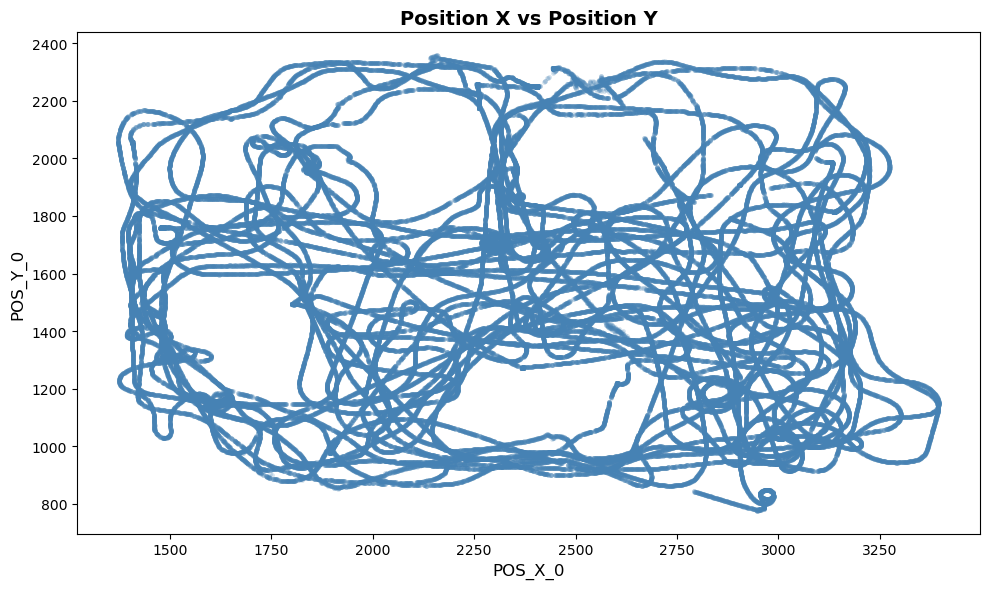

In [70]:

# Create a pretty dot plot of POS_X_0 vs POS_Y_0
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='POS_X_0', y='POS_Y_0', alpha=0.22, s=12, linewidth=0, color='steelblue')
plt.title('Position X vs Position Y', fontsize=14, fontweight='bold')
plt.xlabel('POS_X_0', fontsize=12)
plt.ylabel('POS_Y_0', fontsize=12)
plt.tight_layout()
plt.show()

STEP 9: "Flattening" the CIR data

We discovered count of unique A_IDs to be 6 and unique B_IDs to be 25581. However, total number of datapoints (count of total rows which is 143920) is less than 6 * 25581 = 153486. This means NOT all tags were able to receive signals from every A_IDs. For the purpose of our ML model creation, we will use CIT_t values of zero for the missing A_IDs for a given B_ID.  

Next, to prepare the data for the ML modeling, we will transform the dataframe such that we have only one row per B_ID. The entire RF fingerprint of CIR_ts across six A_IDs will show up as 6 * 366 = 2196 columns. Let's carry out this transformation on the combined_dataframe

In [79]:
# Group by B_ID and create one row per B_ID with CIR_T columns for each A_ID
unique_a_ids = sorted(combined_df["A_ID_0"].unique())
cir_t_cols = [col for col in combined_df.columns if col.startswith("CIR_T_")]

# Create a new dataframe structure
result_data = []

for b_id in combined_df["B_ID_0"].unique():
    b_id_group = combined_df[combined_df["B_ID_0"] == b_id]

    # Start with values from first row of this B_ID
    row_dict = {
        "B_ID_0": b_id,
        "POS_X_0": b_id_group["POS_X_0"].iloc[0],
        "POS_Y_0": b_id_group["POS_Y_0"].iloc[0],
        "TD_0": b_id_group["TD_0"].iloc[0],
        "TD_OFFSET_0": b_id_group["TD_OFFSET_0"].iloc[0],
        "TIME_STAMP_0": b_id_group["TIME_STAMP_0"].iloc[0],
    }

    # Add CIR_T columns for each A_ID
    for a_id in unique_a_ids:
        a_id_row = b_id_group[b_id_group["A_ID_0"] == a_id]
        a_id_str = (
            a_id.decode() if isinstance(a_id, (bytes, np.bytes_)) else str(a_id)
        )
        a_id_suffix = a_id_str.replace(":", "")

        if len(a_id_row) > 0:
            # Use CIR_T values from this A_ID
            for col in cir_t_cols:
                new_col_name = f"{col}_{a_id_suffix}"
                row_dict[new_col_name] = a_id_row[col].iloc[0]
        else:
            # Fill with 0 if A_ID doesn't exist for this B_ID
            for col in cir_t_cols:
                new_col_name = f"{col}_{a_id_suffix}"
                row_dict[new_col_name] = 0

    result_data.append(row_dict)

result_df = pd.DataFrame(result_data)
print("Resultant DataFrame shape:", result_df.shape)

Resultant DataFrame shape: (25581, 2202)


STEP 10: Save the resultant dataframe into a file so that this ML ready data can be easily used in future modeling exercise.

In [80]:
# Save the compressed version of result_df to uwb_dataset folder
output_path = Path("uwb_dataset") / "result_df_compressed.parquet"
result_df.to_parquet(output_path, compression='gzip', index=False)
print(f"Saved compressed result_df to {output_path}")
print(f"File size: {output_path.stat().st_size / (1024**2):.2f} MB")

Saved compressed result_df to uwb_dataset\result_df_compressed.parquet
File size: 318.51 MB


STEP 11: 
Read the stored data back into a pandas dataframe to confirm that it reads correctly and has the expected shape.

In [3]:
uwb_dataset = pd.read_parquet(Path("uwb_dataset") / "result_df_compressed.parquet")
print(f"Loaded uwb_dataset shape: {uwb_dataset.shape}")

Loaded uwb_dataset shape: (25581, 2202)


In [4]:
print(uwb_dataset.iloc[0])

B_ID_0                    3597.000000
POS_X_0                   1894.568198
POS_Y_0                    978.793266
TD_0                        44.964108
TD_OFFSET_0                 95.207301
                             ...     
CIR_T_361_B29100000000      50.566788
CIR_T_362_B29100000000      90.138782
CIR_T_363_B29100000000      76.485293
CIR_T_364_B29100000000      97.616597
CIR_T_365_B29100000000     197.091349
Name: 0, Length: 2202, dtype: float64


STEP 12: GIving the data a "finishing touch"
For our ML Model creation, we will remove the B_ID and TIME_STAMP_0 columns as they are not relevant "features" of the model. Next, we will use standard scalar for the features TD_0 and TD_OFFSET_0. Finally we will normalize the RF Fingerprint data consisting of CIR_t values.

In [5]:
uwb_dataset = uwb_dataset.drop(columns=['B_ID_0', 'TIME_STAMP_0'])
print(f"Updated uwb_dataset shape: {uwb_dataset.shape}")
print(f"Remaining columns: {uwb_dataset.columns.tolist()[:10]}...")  # Show first 10 columns

Updated uwb_dataset shape: (25581, 2200)
Remaining columns: ['POS_X_0', 'POS_Y_0', 'TD_0', 'TD_OFFSET_0', 'CIR_T_0_668900000000', 'CIR_T_1_668900000000', 'CIR_T_2_668900000000', 'CIR_T_3_668900000000', 'CIR_T_4_668900000000', 'CIR_T_5_668900000000']...


In [ ]:
scaler = StandardScaler()

# Let's standardize TD_0 and TD_OFFSET_0
uwb_dataset[["TD_0", "TD_OFFSET_0"]] = scaler.fit_transform(
    uwb_dataset[["TD_0", "TD_OFFSET_0"]]
)

# Let's normalize all CIR_T columns so max absolute value <= 1
cir_t_cols = [c for c in uwb_dataset.columns if c.startswith("CIR_T_")]
max_abs = uwb_dataset[cir_t_cols].abs().to_numpy().max()
if max_abs > 0:
    uwb_dataset[cir_t_cols] = uwb_dataset[cir_t_cols] / max_abs

STEP 13: With the CIR_T values normalized, we will train a Multi Layer Perceptron model that outputs a two dimensional location (POS_X, POS_Y). We will use ReLU activation function, Adam optimization and 4 layers. For this time, we will train over 150 epochs. We will track the Mean squared error (in units of square centimeters). Our objective is to get the RMSE in sub meter ( < 100 cm or < 1 m) range.

Epoch 10/150  Train MSE: 142558.3298  Test MSE: 125611.2532
Epoch 20/150  Train MSE: 106678.4232  Test MSE: 89440.0262
Epoch 30/150  Train MSE: 47966.3114  Test MSE: 32489.5144
Epoch 40/150  Train MSE: 22562.7351  Test MSE: 897354.3585
Epoch 50/150  Train MSE: 17046.3566  Test MSE: 11822.7914
Epoch 60/150  Train MSE: 15444.0943  Test MSE: 608526.4756
Epoch 70/150  Train MSE: 14236.2084  Test MSE: 300883.4716
Epoch 80/150  Train MSE: 13706.2363  Test MSE: 455894.1277
Epoch 90/150  Train MSE: 13175.6838  Test MSE: 434196.7964
Epoch 100/150  Train MSE: 12949.5888  Test MSE: 413953.7787
Epoch 110/150  Train MSE: 12888.5785  Test MSE: 429683.7880
Epoch 120/150  Train MSE: 12894.2147  Test MSE: 472868.3145
Epoch 130/150  Train MSE: 12666.8671  Test MSE: 455979.6336
Epoch 140/150  Train MSE: 12704.9754  Test MSE: 472338.4110
Epoch 150/150  Train MSE: 12831.2588  Test MSE: 452152.5691


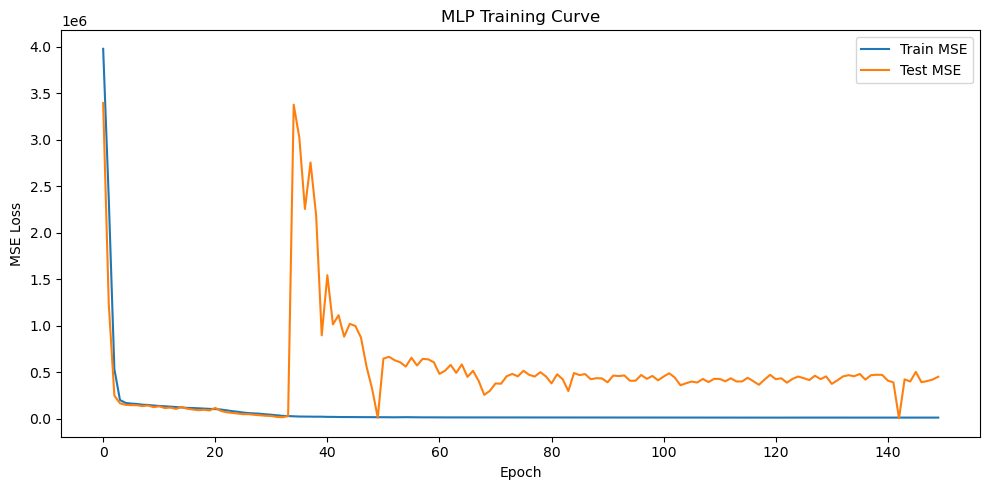


Final Test RMSE: 672.42 cm
Number of features: 2198
Model parameters: 2,944,642


In [ ]:
# Lets define model features and labels
feature_cols = ["TD_0", "TD_OFFSET_0"] + [c for c in uwb_dataset.columns if c.startswith("CIR_T_")]
label_cols = ["POS_X_0", "POS_Y_0"]

X = uwb_dataset[feature_cols].values
y = uwb_dataset[label_cols].values

# Let's now do the Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's convert X & y to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=256, shuffle=False)

# Let's define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=len(feature_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
criterion = nn.MSELoss()

# Let's implement the Training loop
n_epochs = 150
train_losses, test_losses = [], []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_loss = epoch_loss / len(X_train)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)
    test_loss /= len(X_test)
    test_losses.append(test_loss)
    scheduler.step(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}  Train MSE: {train_loss:.4f}  Test MSE: {test_loss:.4f}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(test_losses, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("MLP Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Final RMSE in cm
final_rmse = test_losses[-1] ** 0.5
print(f"\nFinal Test RMSE: {final_rmse:.2f} cm")
print(f"Number of features: {len(feature_cols)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

MLP Model Training Results / Conclusion

Clearly our baseline MLP model suffers from overfitting problem. While Training RMSE (sqrt [12831] = 113 cm) came close to the desired objective of 100 cm, test RMSE is much higher. We need to either try different hyperparameters or look at alternate models such as 1D CNN.